In [1]:
from lang2vec import lang2vec as l2v
import yaml

In [2]:
# Code adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [3]:
with open('languages.yaml', 'r') as f:
    language_data = yaml.safe_load(f)

vectors = l2v.get_features(list(language_data.keys()), 'syntax_knn')
language_data.update({k: {**v, 'vector': np.array(vectors[k], dtype=float)} for k, v in language_data.items()})

language_data = {k: v for k, v in language_data.items() if k in ('deu', 'nld', 'swe', 'ces', 'hun', 'gsw', 'fao', 'hsb', 'vep')}

X = np.array([v['vector'] for v in language_data.values()])

In [4]:
help(AgglomerativeClustering)

Help on class AgglomerativeClustering in module sklearn.cluster._agglomerative:

class AgglomerativeClustering(sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  AgglomerativeClustering(n_clusters=2, *, metric='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward', distance_threshold=None, compute_distances=False)
 |  
 |  Agglomerative Clustering.
 |  
 |  Recursively merges pair of clusters of sample data; uses linkage distance.
 |  
 |  Read more in the :ref:`User Guide <hierarchical_clustering>`.
 |  
 |  Parameters
 |  ----------
 |  n_clusters : int or None, default=2
 |      The number of clusters to find. It must be ``None`` if
 |      ``distance_threshold`` is not ``None``.
 |  
 |  metric : str or callable, default="euclidean"
 |      Metric used to compute the linkage. Can be "euclidean", "l1", "l2",
 |      "manhattan", "cosine", or "precomputed". If linkage is "ward", only
 |      "euclidean" is accepted. If "precomputed", a distance 

In [5]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='cosine', linkage='average')
model = model.fit(X)

ValueError: Dimensions of Z and labels must be consistent.

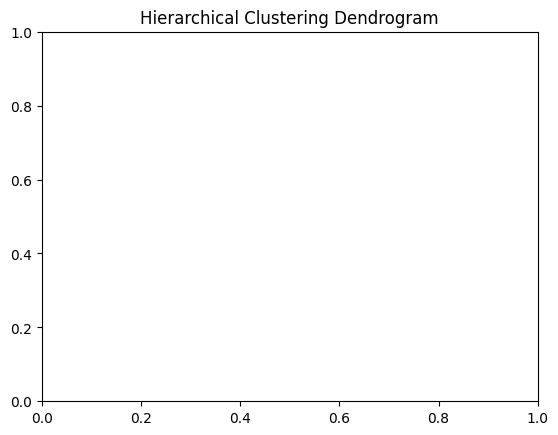

In [9]:
# plt.figure(figsize=(32, 16), dpi=300)

language_names = [v['name'] for v in language_data.values()]
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, labels=language_names)

plt.xlabel("Languages")
plt.xticks(rotation=45, fontsize=10)
plt.savefig('hcd.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Find low-resource languages

In [7]:
with open('languages.yaml', 'r') as f:
    language_data = yaml.safe_load(f)

vectors = l2v.get_features(list(language_data.keys()), 'syntax_knn')
language_data.update({k: {**v, 'vector': np.array(vectors[k], dtype=float)} for k, v in language_data.items()})

lrls = [k for k, v in language_data.items() if v['wiki-size'] == 0]

In [8]:
from scipy.spatial.distance import cosine

mid_langs = ['nld', 'swe', 'ces', 'hun']
ranked_sims = {}

for mid in mid_langs:
    V_lang = language_data[mid]['vector']
    sims = {}
    for lrl in lrls:
        sims[lrl] = 1 - cosine(V_lang, language_data[lrl]['vector'])
    sorted_langs = sorted(sims.items(), key=lambda x: x[1], reverse=True)[:5]
    ranked_sims[mid] = sorted_langs


ranked_sims

{'nld': [('gsw', np.float64(0.9417632186960222)),
  ('fao', np.float64(0.8867155358917449)),
  ('lij', np.float64(0.8193365776101958)),
  ('nap', np.float64(0.8097533639902196)),
  ('aln', np.float64(0.7952384429746018))],
 'swe': [('fao', np.float64(0.9210526315789473)),
  ('gsw', np.float64(0.9048645778823592)),
  ('aln', np.float64(0.8510644963469901)),
  ('lij', np.float64(0.8510644963469901)),
  ('hsb', np.float64(0.8510644963469901))],
 'ces': [('hsb', np.float64(0.9001028747788694)),
  ('aln', np.float64(0.8486684247915055)),
  ('fao', np.float64(0.8381440091756065)),
  ('lij', np.float64(0.8229511997978235)),
  ('pus', np.float64(0.8229511997978235))],
 'hun': [('vep', np.float64(0.8804087784801333)),
  ('mdf', np.float64(0.8690481892534816)),
  ('krl', np.float64(0.867442794919067)),
  ('kpv', np.float64(0.867442794919067)),
  ('olo', np.float64(0.867442794919067))]}